In [2]:
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
MAIN_COLOR_1 = "#7D92C3"
MAIN_COLOR_2 = "#4664AA"
ACCENT_COLOR = "#902020"

CLASSES = ["Athlete"]

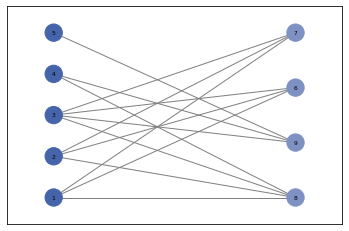

In [25]:
G = nx.Graph()
G.add_edges_from([(1,6),(1,7),(1,8),(2,6),(2,7),(2,8),(3,6),(3,7),(3,8),(3,9),(4,8),(4,9),(5,9)])

coloring = nx.greedy_color(G, strategy="largest_first")
nodecolors = []
for node in G.nodes():
    if coloring[node] == 0:
        nodecolors.append(MAIN_COLOR_1)
    else:
        nodecolors.append(MAIN_COLOR_2)

top = nx.bipartite.sets(G)[0]
bi_layout = nx.bipartite_layout(G, top, aspect_ratio=0.5, scale=0.2)
nx.draw_networkx(G, bi_layout, with_labels=True, font_size=6,node_color=nodecolors, edge_color="grey")


404910 nodes with degree >= 1 and 5 disconnected nodes


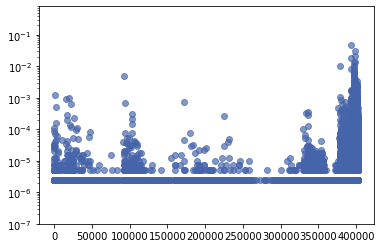

In [47]:
with open(f"out/{CLASSES[0]}.t.k.json", "r") as input_file:
    dist = json.load(input_file)

nnodes = 404915 # TODO
ndiscnodes = nnodes - sum

sum = 0
for key, value in dist.items():
    sum += value

x = []
y = []
for key, value in dist.items():
    x.append(int(key))
    y.append(float(value / sum))
    
print(f"{sum} nodes with degree >= 1 and {ndiscnodes} disconnected nodes")
x.append(0)
y.append(float(ndiscnodes / sum))

# plt.xscale("log")
# plt.xlim(0.1, 800000)
plt.yscale("log")
plt.ylim(0.0000001, 0.8)
plt.scatter(x, y, color=MAIN_COLOR_2+"aa")
plt.show()

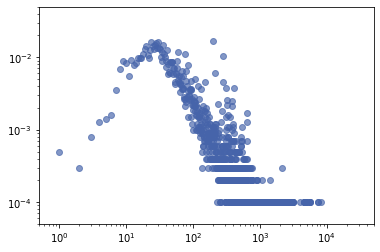

In [89]:
with open(f"out/{CLASSES[0]}.b.k.json", "r") as input_file:
    dist = json.load(input_file)

sum = 0
for key, value in dist.items():
    sum += value

x = []
y = []
for key, value in dist.items():
    x.append(int(key))
    y.append(float(value / sum))

plt.xscale("log")
plt.xlim(0.5, 50000)
plt.yscale("log")
plt.ylim(0.00005, 0.05)
plt.scatter(x, y, color=MAIN_COLOR_2+"aa")
plt.show()

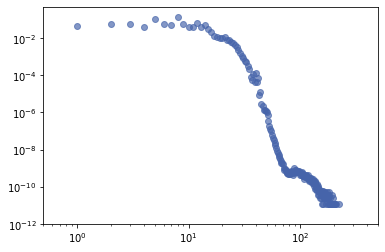

In [67]:
with open(f"out/{CLASSES[0]}.t.w.json", "r") as input_file:
    dist = json.load(input_file)

sum = 0
for key, value in dist.items():
    if int(key) > 0:
        sum += value

x = []
y = []
for key, value in dist.items():
    if int(key) > 0:
        x.append(int(key))
        y.append(float(value / sum))

plt.xscale("log")
plt.xlim(0.5, 500)
plt.yscale("log")
plt.ylim(0.000000000001, 0.5)
plt.scatter(x, y, color=MAIN_COLOR_2+"aa")
plt.show()

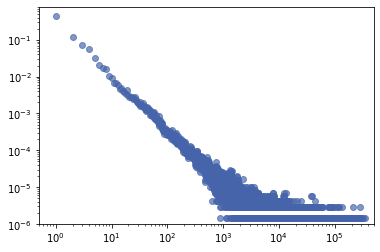

In [80]:
with open(f"out/{CLASSES[0]}.b.w.json", "r") as input_file:
    dist = json.load(input_file)

sum = 0
for key, value in dist.items():
    if int(key) > 0:
        sum += value

x = []
y = []
for key, value in dist.items():
    if int(key) > 0:
        x.append(int(key))
        y.append(float(value / sum))

plt.xscale("log")
plt.xlim(0.5, 500000)
plt.yscale("log")
plt.ylim(0.000001, 0.8)
plt.scatter(x, y, color=MAIN_COLOR_2+"aa")
plt.show()

<BarContainer object of 10030 artists>

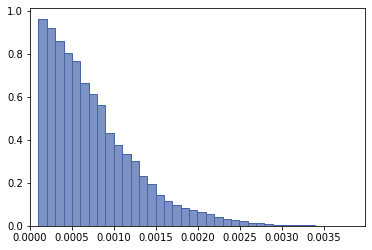

In [87]:
df = pd.read_csv(f"out/{CLASSES[0]}.t.knc.csv")

n_b = 10030
k_max_t = n_b
w_max_t = 40

plt.xlim(0, w_max_t/k_max_t)
plt.bar(df["k"]/k_max_t, df["density"], width=1/k_max_t, align="edge", color=MAIN_COLOR_1, edgecolor=MAIN_COLOR_2)

<BarContainer object of 51 artists>

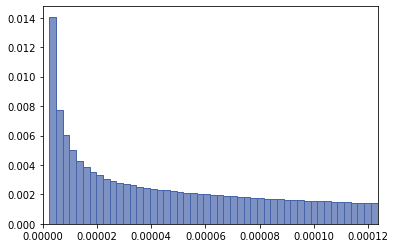

In [22]:
df = pd.read_csv(f"out/{CLASSES[0]}.b.knc.csv")

n_t = 404915
k_max_b = n_t
w_max_b = 50

plt.xlim(0, w_max_b/k_max_b)
plt.bar(df.loc[:w_max_b, "k"]/k_max_b, df.loc[:w_max_b, "density"], width=1/k_max_b, align="edge", color=MAIN_COLOR_1, edgecolor=MAIN_COLOR_2)